In [1]:
import numpy as np
import pandas as pd

from pprint import pprint

from decision_tree_functions import decision_tree_algorithm, make_predictions, calculate_accuracy
from helper_functions import generate_data, create_plot, train_test_split

# 1. Post-Pruning

In [2]:
def filter_df(df, question):
    feature, comparison_operator, value = question.split()
    
    # continuous feature
    if comparison_operator == "<=":
        df_yes = df[df[feature] <= float(value)]
        df_no =  df[df[feature] >  float(value)]
        
    # categorical feature
    else:
        df_yes = df[df[feature].astype(str) == value]
        df_no  = df[df[feature].astype(str) != value]
    
    return df_yes, df_no

In [3]:
def determine_leaf(df_train, ml_task):
    
    if ml_task == "regression":
        return df_train.label.mean()
    
    # classification
    else:
        return df_train.label.value_counts().index[0]

In [4]:
def determine_errors(df_val, tree, ml_task):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val.label
    
    if ml_task == "regression":
        # mean squared error
        return ((predictions - actual_values) **2).mean()
    else:
        # number of errors
        return sum(predictions != actual_values)

In [5]:
def pruning_result(tree, df_train, df_val, ml_task):
    
    leaf = determine_leaf(df_train, ml_task)
    errors_leaf = determine_errors(df_val, leaf, ml_task)
    errors_decision_node = determine_errors(df_val, tree, ml_task)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

In [6]:
def post_pruning(tree, df_train, df_val, ml_task):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val, ml_task)
        
    # recursive part
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes, ml_task)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no, ml_task)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val, ml_task)

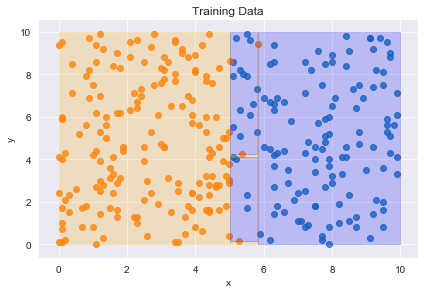

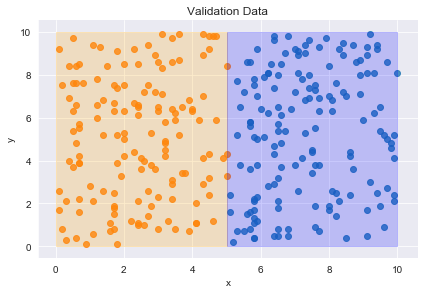

In [7]:
# np.random.seed(0)
df_train = generate_data(n=300, n_random_outliers=5)
tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=10)
create_plot(df_train, tree, title="Training Data")

# np.random.seed(7)
df_val = generate_data(n=300)
tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")
create_plot(df_val, tree_pruned, title="Validation Data")

# 2. Titanic Data Set (Classification Task)

## 2.1 Data Preparation
- the last column of the data frame must contain the label and it must also be called "label"
- there should be no missing values in the data frame

In [8]:
df = pd.read_csv("../data/Titanic.csv")
df["label"] = df.Survived
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

# handling missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]

df = df.fillna({"Age": median_age, "Embarked": mode_embarked})

## 2.2 Post-Pruning
Comparing the accuracy of the tree before and after post-pruning using different values for the "max_depth" parameter.

In [9]:
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_pruned": []}
for n in range(10, 26):
    df_train, df_test = train_test_split(df, test_size=0.15)
    df_train, df_val = train_test_split(df_train, test_size=0.15)

    tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=n)
    tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")
    
    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    metrics["acc_tree_pruned"].append(calculate_accuracy(df_test, tree_pruned))
    
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("max_depth")

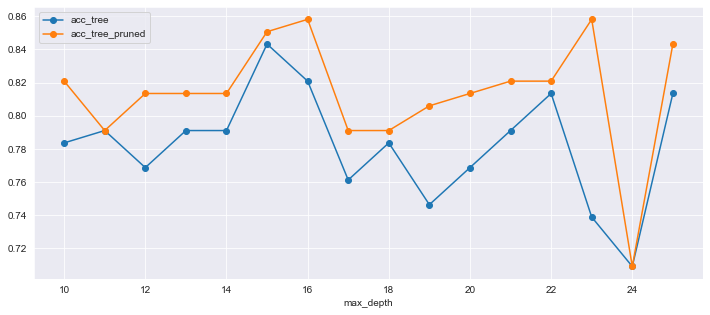

In [10]:
df_metrics.plot(figsize=(12, 5), marker="o")

# 3. Bike Rental Data Set (Regression Task)

## 3.1 Data Preparation
- the last column of the data frame must contain the label and it must also be called "label"
- there should be no missing values in the data frame

In [11]:
df = pd.read_csv("../data/Bike.csv", parse_dates=["dteday"])
df = df.drop(["instant", "casual", "registered"], axis=1)
df = df.rename({"dteday": "date"}, axis=1)

In [12]:
date_column = df.date

df["day_of_year"] = date_column.dt.dayofyear
df["day_of_month"] = date_column.dt.day

df["quarter"] = date_column.dt.quarter
df["week"] = date_column.dt.week

df["is_month_end"] = date_column.dt.is_month_end
df["is_month_start"] = date_column.dt.is_month_start
df["is_quarter_end"] = date_column.dt.is_quarter_end
df["is_quarter_start"] = date_column.dt.is_quarter_start
df["is_year_end"] = date_column.dt.is_year_end
df["is_year_start"] = date_column.dt.is_year_start

df = df.set_index("date")

In [13]:
df["label"] = df.cnt
df = df.drop("cnt", axis=1)

In [14]:
df_train = df.iloc[:-122]
df_val = df.iloc[-122:-61]  # Sep and Oct of 2012
df_test = df.iloc[-61:]     # Nov and Dec of 2012

## 3.2 Post-Pruning
Comparing the mean squared error of the tree before and after post-pruning.

In [15]:
tree = decision_tree_algorithm(df_train, ml_task="regression", max_depth=10)
tree_pruned = post_pruning(tree, df_train, df_val, ml_task="regression")

mse_tree = determine_errors(df_test, tree, ml_task="regression")
mse_tree_pruned = determine_errors(df_test, tree_pruned, ml_task="regression")

print(f"MSE of Tree:        {int(mse_tree):,}")
print(f"MSE of pruned Tree: {int(mse_tree_pruned):,}")

MSE of Tree:        2,274,382
MSE of pruned Tree: 1,746,315


Comparing the predictions of the tree before and after post-pruning.

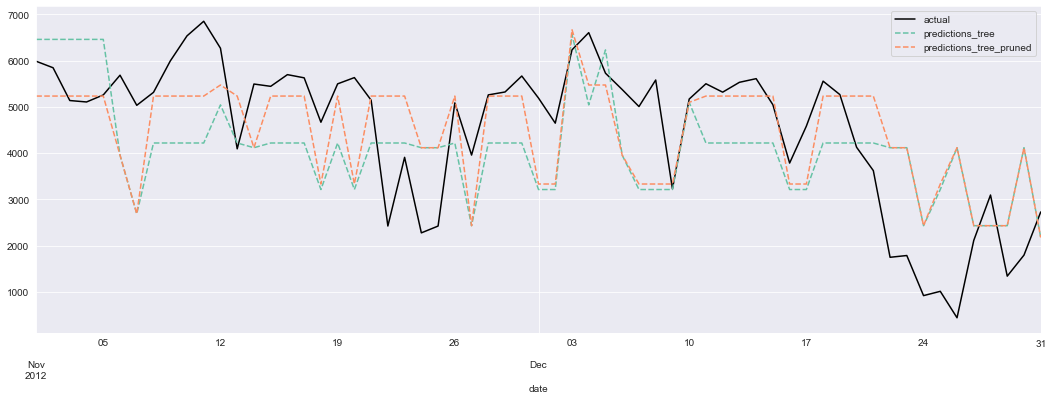

In [16]:
df_plot = pd.DataFrame({"actual": df_test.label,
                        "predictions_tree": make_predictions(df_test, tree),
                        "predictions_tree_pruned": make_predictions(df_test, tree_pruned)})

df_plot.plot(figsize=(18, 6), color=["black", "#66c2a5", "#fc8d62"], style=["-", "--", "--"]);